# Centroiding with *ballet*

To use the [Ballet](eloy.ballet.model.Ballet) centroiding model in your pipelines, first instantiate the model

In [1]:
from eloy.ballet import Ballet

cnn = Ballet()

And then use it in [eloy.centroid.ballet_centroid](eloy.centroid.ballet_centroid). Here is an example on one of the [calibrated image dataset](calibration)

In [2]:
from astropy.io import fits
from eloy import detection, centroid
import numpy as np

image = fits.getdata("calibrated_images/ESPC WASP-1245.000secs00000009.fits").astype(
    float
)
regions = detection.stars_detection(image)
coords = np.array([region.centroid_weighted[::-1] for region in regions])

centroids = centroid.ballet_centroid(image, coords, cnn)

## The model

Ballet is a convolutional neural network that computes the centroid of star cutouts. It is as accurate as fitting a 2D Gaussian to the profile but ~20x faster. Let's show that on our image.

### Speed

We compute the evaluation time from photutils `centroid_2dg` function against [eloy.centroid.ballet_centroid](eloy.centroid.ballet_centroid)

In [3]:
from photutils.centroids import centroid_2dg

%timeit centroid.photutils_centroid(image, coords, centroid_fun=centroid_2dg)
%timeit centroid.ballet_centroid(image, coords, cnn)

233 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.7 ms ± 611 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Precision

As for the precision, let's simulate a set of Moffat profiles and compare the centroid_2dg function to [Ballet](eloy.ballet.model.Ballet).

In [ ]:
from eloy.ballet.training import Moffat2D

cutouts, truth = Moffat2D(15).random_model_label(10000)
# this one will take a while
centroid_photutils = np.array(
    [centroid_2dg(cutout)[::-1] for cutout in cutouts[..., 0]]
)
centroid_ballet = cnn.centroid(cutouts[..., 0])[:, ::-1]

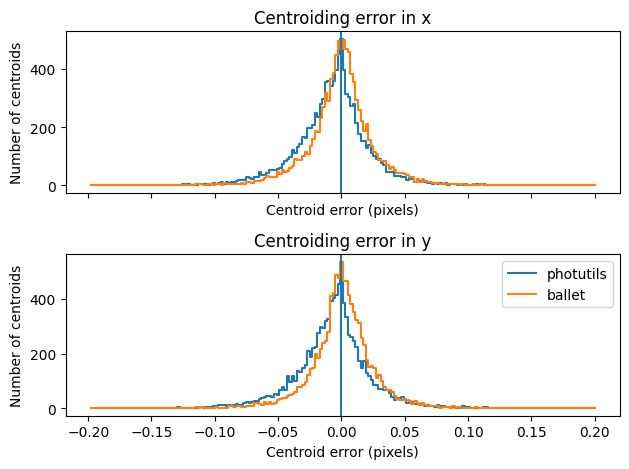

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, sharex=True)
bins = np.linspace(-0.2, 0.2, 200)
axes[0].step(
    bins[1:],
    np.histogram((centroid_photutils - truth)[:, 0], bins)[0],
    label="photutils",
)
axes[0].step(
    bins[1:], np.histogram((centroid_ballet - truth)[:, 0], bins)[0], label="ballet"
)
axes[0].axvline(0)
axes[0].set_xlabel("Centroid error (pixels)")
axes[0].set_ylabel("Number of centroids")
axes[0].set_title("Centroiding error in x")


axes[1].step(
    bins[1:],
    np.histogram((centroid_photutils - truth)[:, 1], bins)[0],
    label="photutils",
)
axes[1].step(
    bins[1:], np.histogram((centroid_ballet - truth)[:, 1], bins)[0], label="ballet"
)
axes[1].axvline(0)
axes[1].set_title("Centroiding error in y")
axes[1].set_xlabel("Centroid error (pixels)")
axes[1].set_ylabel("Number of centroids")

plt.legend()
plt.tight_layout()

As precise as photutils, but much faster!